# A simple example of semantic segmentation with tensorflow keras

The field of deep learning is vast. The sheer number of publications on the subject is enough to make anyone overwhelmed. In the series "Simple deep learning" we'll be taking a step back. We'll forget about the latest tips and tricks that are pushing the state of the art. Instead, through the use of simple datasets and toy problems, we'll explore the basis of deep learning to give you a better understanding of the big picture.

This post is about semantic segmentation. This is the task of assigning a label to each pixel of an images. It can be seen as an image classification task, except that instead of classifying the whole image, you're classifying each pixel individually. From this perspective, semantic segmentation is actually very simple. Let's see how we can build a model using Keras to perform semantic segmentation.

This tutorial is posted on [my blog](https://awaywithideas.com/a-simple-example-of-semantic-segmentation-with-tensorflow-keras/) and in my [github repository](https://github.com/LukeTonin/simple-deep-learning/blob/main/semantic_segmentation.ipynb) where you can find the jupyter notebook version of this post.

We're going to use MNIST extended, a toy dataset I created that's great for exploring and playing around with deep learning models. In this post, we won't look into how the data is generated, for more information on that, you can checkout my post : [MNIST Extended: A simple dataset for image segmentation and object localisation](https://awaywithideas.com/mnist-extended-a-dataset-for-semantic-segmentation-and-object-detection/)

In this post I assume a basic understanding of deep learning computer vision notions such as convolutional layers, pooling layers, loss functions, tensorflow/keras etc.

## Import packages

Let's start by importing a few packages. I've printed the tensorflow version we're importing. We'll only be using very simple features of the package, so any version of tensorflow 2 should work.

In [2]:
!pip install matplotlib seaborn

  Using cached matplotlib-3.5.2-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached kiwisolver-1.4.2-cp38-cp38-win_amd64.whl (55 kB)
  Using cached fonttools-4.33.3-py3-none-any.whl (930 kB)
  Using cached Pillow-9.1.0-cp38-cp38-win_amd64.whl (3.3 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pandas-1.4.2-cp38-cp38-win_amd64.whl (10.6 MB)


In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
print(np.__version__)

import keras
print(keras.__version__)

import matplotlib
from matplotlib import pyplot as plt
print(matplotlib.__version__)

2.10.0-dev20220515
1.22.3
2.10.0
3.5.2


In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Dataset

In [5]:
# X_train = np.load("./datasets/X_seg_mnist_train_1.npy")
# y_train = np.load("./datasets/y_seg_mnist_train_1.npy")
# X_test = np.load("./datasets/X_seg_mnist_test.npy")
# y_test = np.load("./datasets/y_seg_mnist_test.npy")
from generator import generate_mnist_dataset, X_mnist_test, X_mnist_train, y_mnist_test, y_mnist_train
X_train, y_train = generate_mnist_dataset(X_mnist_train, y_mnist_train, 5000)
X_test, y_test = generate_mnist_dataset(X_mnist_test, y_mnist_test, 200)

0


C:\Users\user\Projects\semantic-segmentation\segmentation_dataset_generator\array_overlay.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return output_array, np.array(arrays_overlaid), labels_overlaid, bounding_boxes_overlaid


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
0
100
0
100


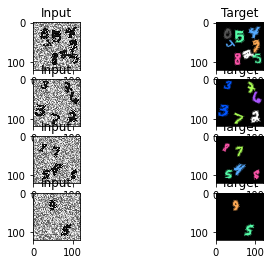

In [6]:
import numpy as np

def colorize_target(target):
    colors = np.array([
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [0, 1, 3],
        [1, 2, 3],
        [1, 3, 2],
        [2, 1, 3],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1],
    ]) / 3
    output_array = np.zeros((target.shape[0], target.shape[1], 3))
    for index in range(0,10):
        output_array[target[:,:,index] > 0] = colors[index]
    return output_array

plt.rcParams['figure.figsize'] = (8,16) # Make the figures a bit bigger
for i in range(0, 8, 2):
    plt.subplot(4,2,i+1)
    num = np.random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Input")
    plt.subplot(4,2,i+2)
    plt.imshow(colorize_target(y_train[num]))
    plt.title("Target")

I've printed the shapes of the train inputs and targets. As expected the input is a grayscale image. The output is slightly strange however, it's essentially a grayscale image for each class we have in our semantic segmentation task. Here we chose num_classes=3 (i.e digits 0, 1 and 2) so our target has a last dimension of length 3. If this is strange to you, I strongly recommend you check out my post on the [MNIST extended](...) where I explain this semantic segmentation dataset in more detail.

## Modelling

### Model architechture

This post is part of the simple deep learning series. My objective here is to achieve reasonably good results with a simple model. This helps understand the core concepts related to a particular deep learning task. It's then very possible to gradually include components from state of the art models to achieve better results or a more efficient model.

Before I give you the simplest model architecture for semantic segmentation, I'd like you to spend a bit of time trying to imagine what that would be.

Need help? I'll give you a hint. For semantic segmentation, the width and height of our output should be the same as our input (semantic segmentation is the task of classifying each pixel individually) and the number of channels should be the number of classes to predict.

The simplest model that achieves that is simply a stack of 2D convolutional layers! It's that simple. If you're familiar with image classification, you might remember that you need pooling to gradually reduce the input size on top of which you add a dense layer. For semantic segmentation this isn't even needed because your output is the same size as the input! This very simple model of stacking convolutional layers is called a Fully Convolutional Network (FCN).

Let's see whether this is good enough. We'll be using tf.keras's [sequential API](https://keras.io/api/models/sequential/) to create the model.

In [8]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=y_train.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 32)        9

About 75000 trainable parameters. For reference, VGG16, a well known model for image feature extraction contains 138 million parameters. In comparison, our model is tiny. That's good, because it means we should be able to train it quickly on CPU.

Let's choose our training parameters. Adam is my go to gradient descent based optimisation algorithm, I don't want to go into the details of how adam works but it's often a good default that I and [others](https://www.youtube.com/watch?v=JXQT_vxqwIs) recommend.

For the loss function, I chose [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy). This is a good loss when your classes are non exclusive which is the case here. If your labels are exclusive, you might want to look at [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) or something else.

Keras allows you to add metrics to be calculated while the model is training. These don't influence the training process but are useful to follow training performance. Accuracy is often the default, but here accuracy isn't very meaningful. Our classes are so imbalanced (i.e a lot more pixels are background than they are digits) that even a model that always predicts 0 will have a great accuracy. For that reason I added [recall and precision](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), those metrics are a lot more useful to evaluate performance, especially in the case of a class imbalance.
I was slightly worried that the class imbalance would prevent the model from learning (I think it does a bit at the beginning) but eventually the model learns.

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

### Train and evaluate

Let's train the model for 20 epochs. This takes about 11 minutes on my 2017 laptop with CPU only. If you have GPU available, then use it. Your model will train a lot faster (approx 10x speed depending on your GPU/CPU). If you're familiar with [Google Colab](https://colab.research.google.com/) then then you can also run the notebook version of the tutorial on there and utilise the free GPU/TPU available on the platform (you will need to copy or install the simple_deep_learning package to generate the dataset).

In [10]:
history = model.fit(X_train, y_train, epochs=20, batch_size=100,
                    validation_data=(X_test, y_test))

Epoch 1/20
10/10 [==============================] - 73s 7s/step - loss: 0.0253 - binary_accuracy: 0.9910 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0247 - val_binary_accuracy: 0.9910 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 54s 5s/step - loss: 0.0238 - binary_accuracy: 0.9911 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0234 - val_binary_accuracy: 0.9911 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 52s 5s/step - loss: 0.0228 - binary_accuracy: 0.9911 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0227 - val_binary_accuracy: 0.9911 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/20
10/10 [==============================] - 52s 5s/step - loss: 0.0223 - binary_accuracy: 0.9911 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0224 - val_binary_accuracy: 0.9911 - val_recall: 0.0000e+00 - val_precision: 0.0

We've stopped the training before the loss plateaued, as you can see, both train and validation loss were still going down after 20 epochs which means that some extra performance might be gained from training longer. However we're not here to get the best possible model.

At the end of epoch 20, on the test set we have an accuracy of 95.6%, a recall of 58.7% and a precision of 90.6%. Remember, these are the metrics for each individual pixel. So the metrics don't give us a great idea of how our segmentation actually looks. To get a better idea, let's look at a few predictions from the test data.

In [11]:
test_y_predicted = model.predict(X_train)

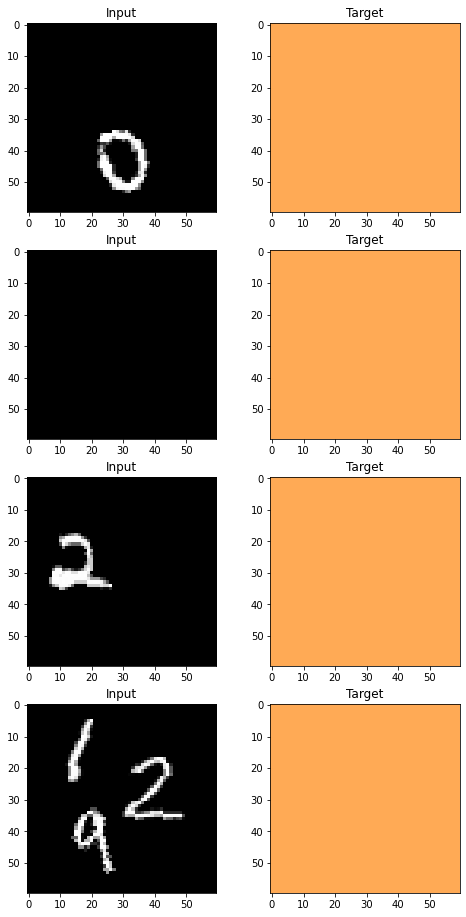

In [12]:
# from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image

# np.random.seed(6)
# for _ in range(3):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#     i = np.random.randint(len(test_y_predicted))
#     print(f'Example {i}')
#     display_grayscale_array(test_x[i], ax=ax1, title='Input image')
#     display_segmented_image(test_y_predicted[i], ax=ax2, title='Segmented image', threshold=0.5)
#     plot_class_masks(test_y[i], test_y_predicted[i], title='y target and y predicted sliced along the channel axis')
plt.rcParams['figure.figsize'] = (8,16) # Make the figures a bit bigger
for i in range(0, 8, 2):
    plt.subplot(4,2,i+1)
    num = np.random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Input")
    plt.subplot(4,2,i+2)
    plt.imshow(colorize_target(test_y_predicted[num]))
    plt.title("Target")

<AxesSubplot:>

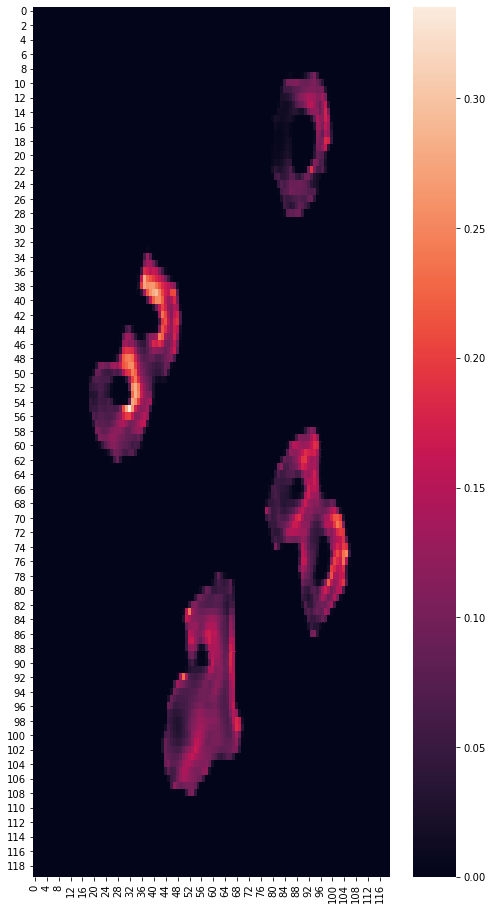

In [30]:
import seaborn as sns
sns.heatmap(test_y_predicted[0,:,:,3])

<AxesSubplot:>

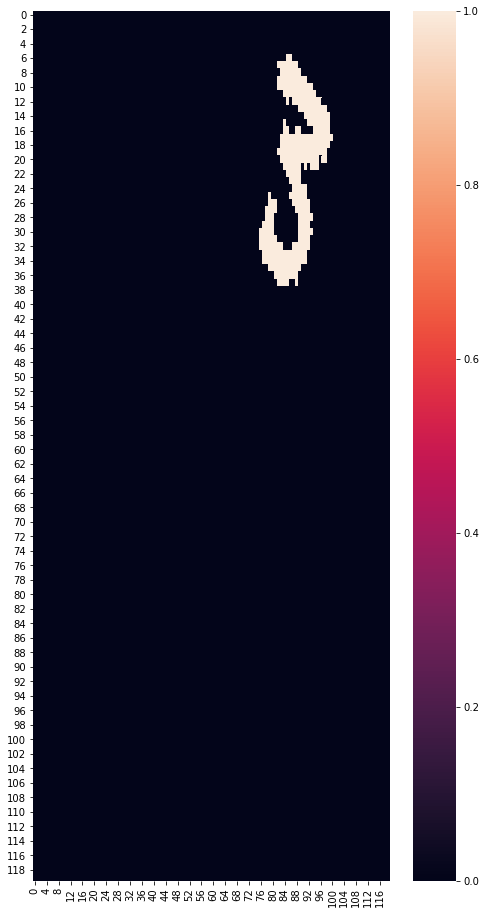

In [32]:
sns.heatmap(y_test[0,:,:,3])

These randomly selected samples show that the model has at least learnt something. It does quite a good job of detecting the digits but it has some problems. By looking at a few examples, it becomes apparent that the model is far from perfect. In my opinion, this model isn't good enough. There's no overfitting the test dataset so we could train for longer, or increase the size of the model but we can do better than that.

We can improve our model by adding few max pooling layers. The first benefit of these pooling layers is computational efficiency. By reducing the size of the intermediate layers, our network performs fewer computations, this will speed up training a bit. However, the number of parameters remains the same because our convolutions are unchanged. The problem with adding the pooling layers is that our output will no longer have the same height and width the input image. To solve that problem we an use upsampling layers. These simple upsampling layers perform essentially the inverse of the pooling layer. A (2, 2) upsampling layer will transform a (height, width, channels) volume into a (height * 2, width * 2, channels) volume simply by duplicating each pixel 4 times. By applying the same number of upsampling layers as max pooling layers, our output is of the same height and width as the input.

Another, more intuitive, benefit of adding the pooling layers is that it forces the network to learn a compressed representation of the input image. It's not totally evident how this helps but by forcing the intermediate layers to hold a volume of smaller height and width than the input, the network is forced to learn the important elements of the input image as a whole as opposed to simply passing all information through. As you'll see, the pooling layers not only improve computational efficiency but also improve the performance of our model!

This idea of compressing a complex input to a compact representation and using that representation to construct an output is a very common idea in deep learning, such models are often called "encoder-decoder" models. They're not only used in computer vision, in this more [advanced deep learning post](https://awaywithideas.com/keras-implementation-of-a-sequence-to-sequence-model-for-time-series-prediction-using-an-encoder-decoder-architecture/), I explore the use of encoder-decoders for time series prediction.

In [9]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=y_train.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                    

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 100,
                    validation_data=(X_test, y_test))

Epoch 1/100
50/50 [==============================] - 18s 131ms/step - loss: 0.1171 - binary_accuracy: 0.9664 - recall: 0.0247 - precision: 0.0078 - val_loss: 0.0214 - val_binary_accuracy: 0.9915 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 3s 63ms/step - loss: 0.0184 - binary_accuracy: 0.9919 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0179 - val_binary_accuracy: 0.9915 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 3s 63ms/step - loss: 0.0168 - binary_accuracy: 0.9919 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0172 - val_binary_accuracy: 0.9915 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
50/50 [==============================] - 3s 63ms/step - loss: 0.0163 - binary_accuracy: 0.9919 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0168 - val_binary_accuracy: 0.9915 - val_recall: 0.0000e+00 - val_precision: 0

Incredibly, this small modification to our model has allowed us to gain 10 percentage points in recall! The training process also takes about half the time.
Let's see how that looks by displaying the examples we checked earlier.

In [10]:
test_y_predicted = model.predict(X_test)

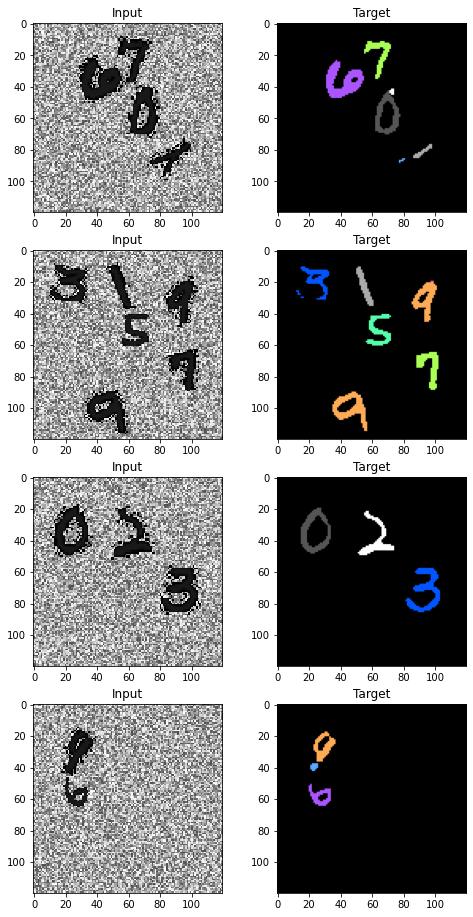

In [34]:
import numpy as np

def colorize_target(target):
    colors = np.array([
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [0, 1, 3],
        [1, 2, 3],
        [1, 3, 2],
        [2, 1, 3],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1],
    ]) / 3
    output_array = np.zeros((target.shape[0], target.shape[1], 3))
    for index in range(0,10):
        output_array[target[:,:,index] > 0.5] = colors[index]
    return output_array

plt.rcParams['figure.figsize'] = (8,16) # Make the figures a bit bigger
for i in range(0, 8, 2):
    plt.subplot(4,2,i+1)
    num = np.random.randint(0, len(X_test))
    plt.imshow(X_test[num], cmap='gray', interpolation='none')
    plt.title("Input")
    plt.subplot(4,2,i+2)
    plt.imshow(colorize_target(test_y_predicted[num]))
    plt.title("Target")

Example 154


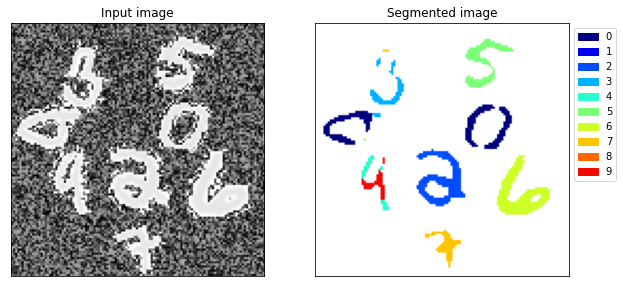

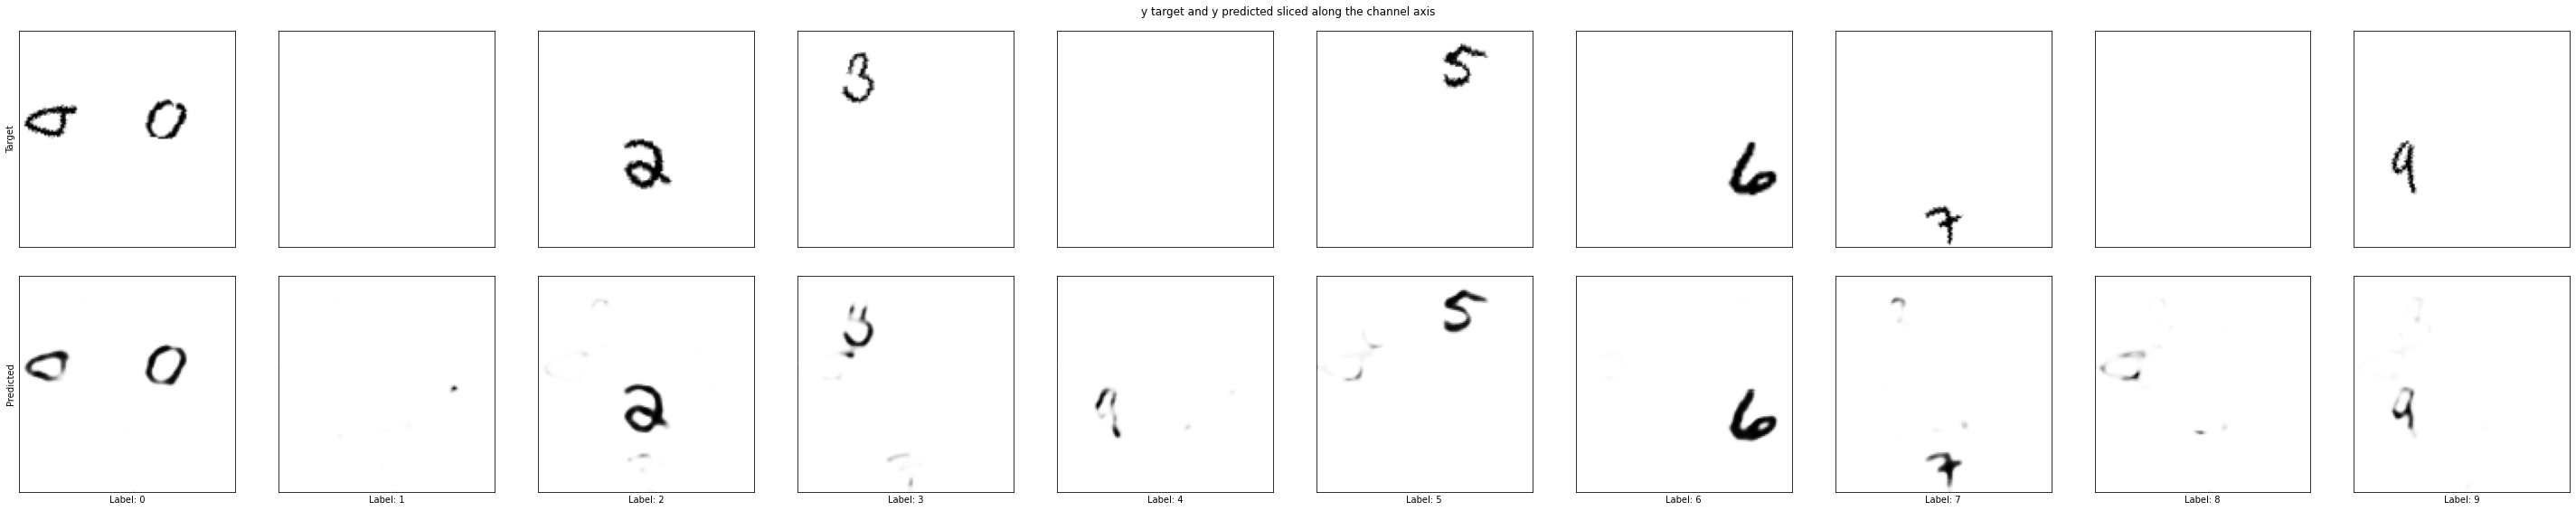

Example 15


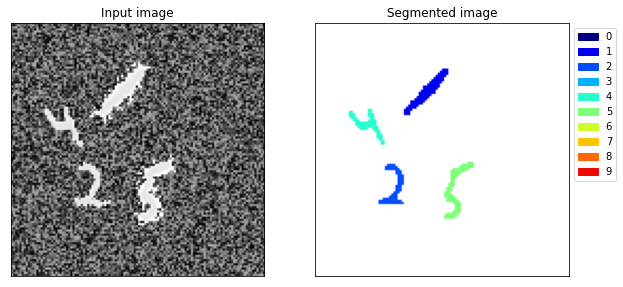

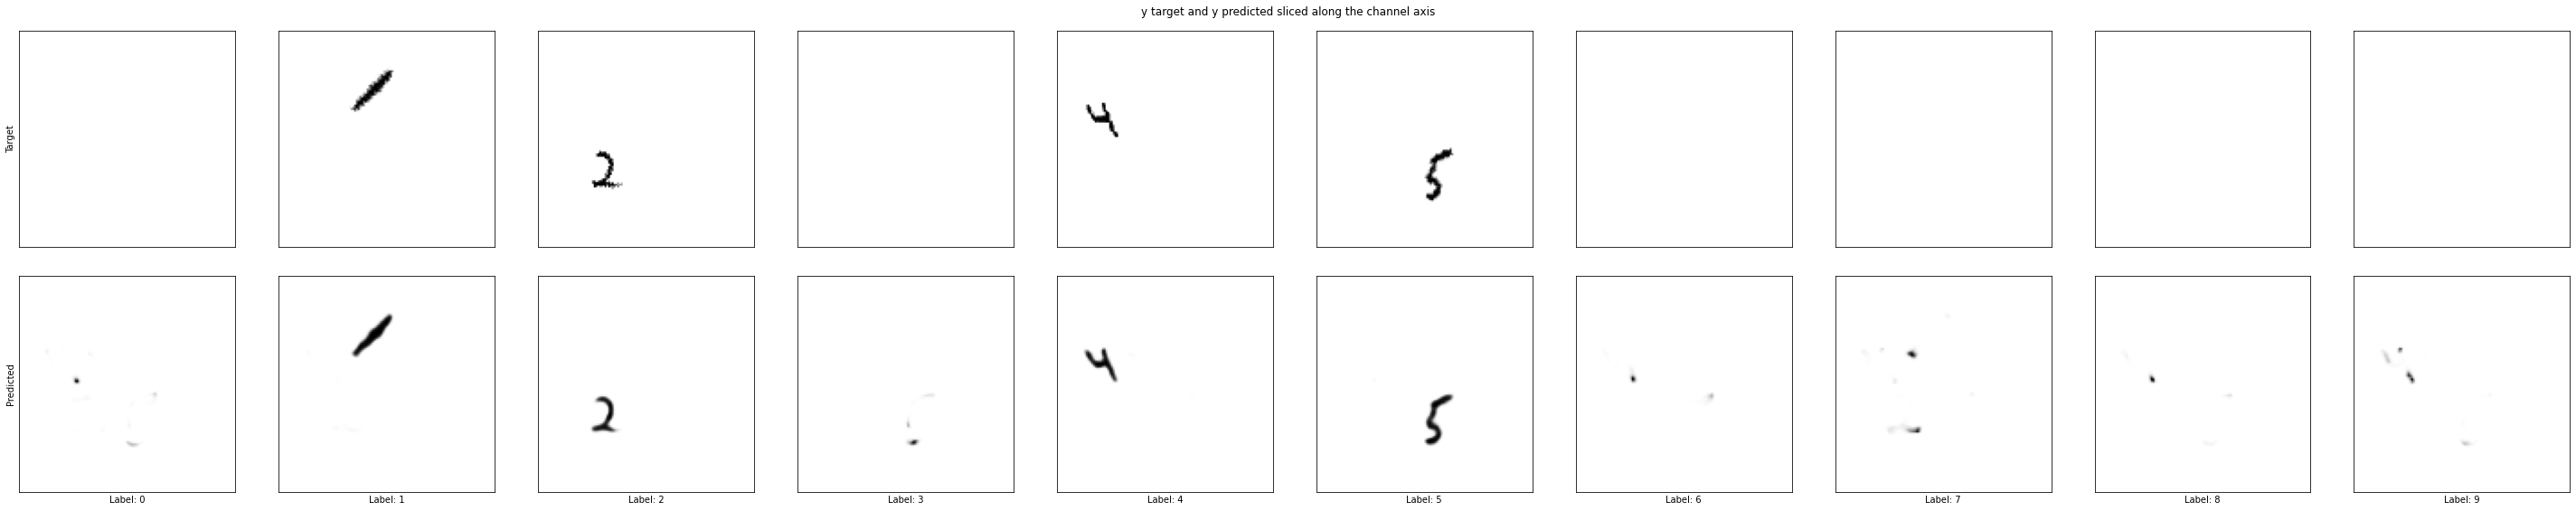

Example 86


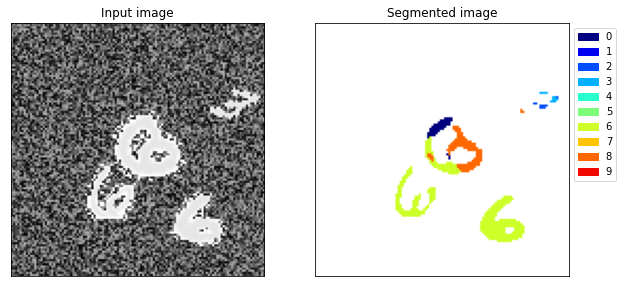

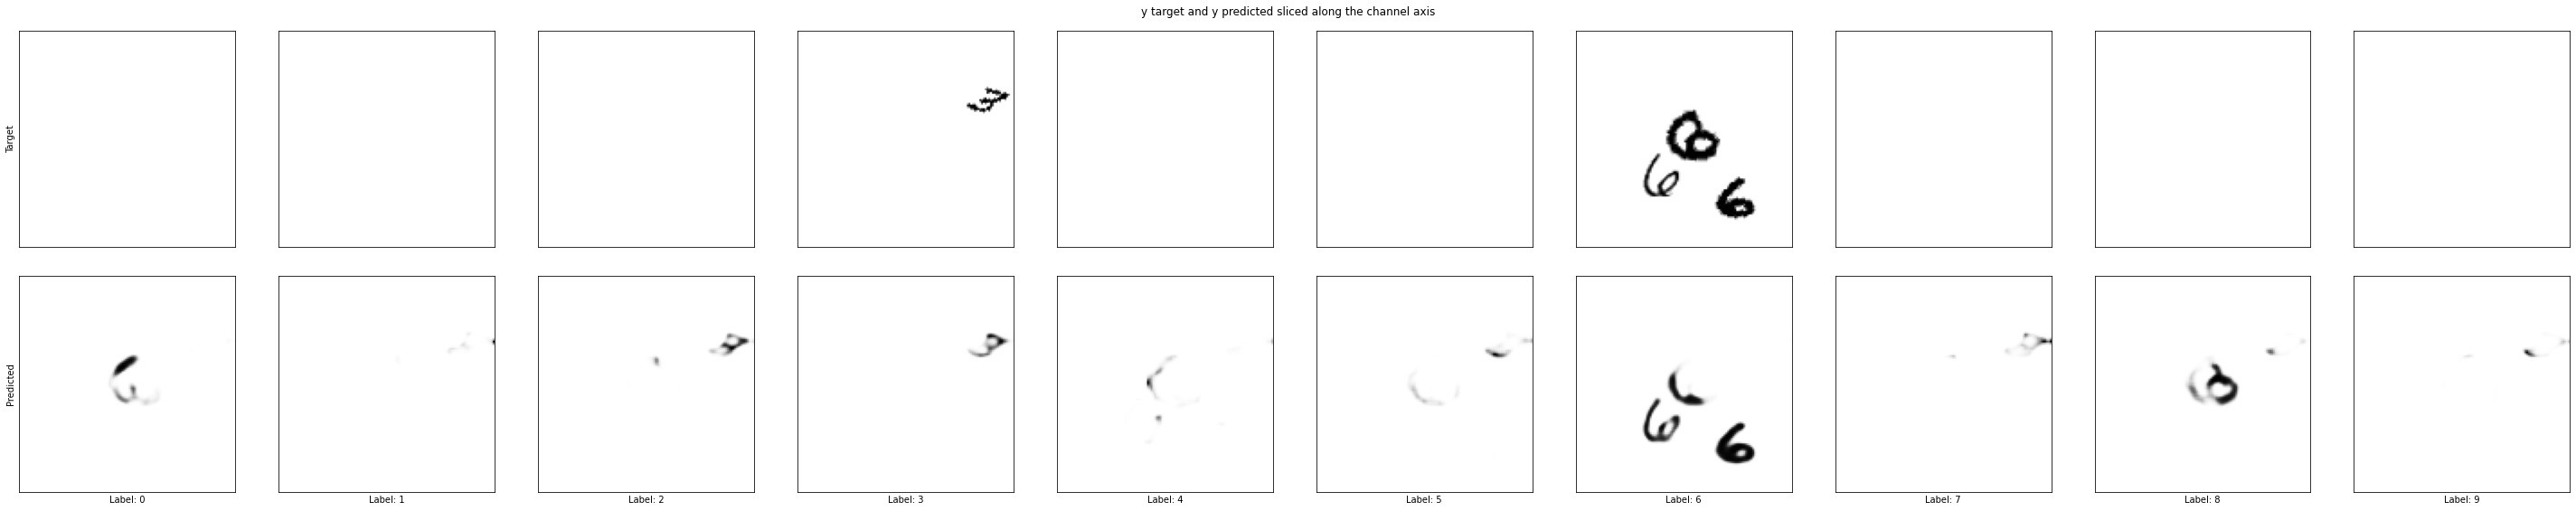

In [36]:

from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image, display_grayscale_array, plot_class_masks

# np.random.seed(6)
for _ in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    i = np.random.randint(len(test_y_predicted))
    print(f'Example {i}')
    display_grayscale_array(X_test[i], ax=ax1, title='Input image')
    display_segmented_image(test_y_predicted[i], ax=ax2, title='Segmented image')
    plot_class_masks(y_test[i], test_y_predicted[i], title='y target and y predicted sliced along the channel axis')

The difference is huge, the model no longer gets confused between the 1 and the 0 (example 117) and the segmentation looks almost perfect.

# Conclusion

State of the art models for semantic segmentation are far more complicated than what we've seen so far. What we've created isn't going to get us on the leaderboard of any semantic segmentation competition... However, hopefully you've understood that the core concepts behind semantic segmentation are actually very simple. This post is just an introduction, I hope your journey won't end here and that I have encouraged you to experiment with your own modelling ideas. You could make the challenge harder by changing the parameters in the create dataset function (increase the number of classes, the number of digits per image...). Perhaps you could look at the concepts that make state of the art semantic segmentation models and try to implement them yourself on this simple dataset. A good starting point is this [great article](https://nanonets.com/blog/semantic-image-segmentation-2020/) that provides an explanation of more advanced ideas in semantic segmentation.

I hope enjoyed reading this post. If you have any questions or have done something cool with the this dataset that you would like to share, comment below or reach out to me on [Linkedin](https://www.linkedin.com/in/luketonin/). I love hearing from you.

Have a great day,  
Luke